# ANATOMY OF QUANTUM ANNEALING WITH D-WAVE ON AMAZON BRAKET

In this tutorial notebook we dive deep into the __anatomy of quantum annealing__ with D-Wave on Amazon Braket.
First, we introduce the concept of quantum annealing as used by D-Wave to probabilistically find the (approximate) optimum to some optimization problem. 
We then discuss D-Wave's underlying Chimera graph, explain the problem of finding an __embedding__ of the original problem onto this sparse Chimera graph, and discuss the distinction between __logical and physical variables__.
Finally, we solve an example QUBO problem to analyze the sampling process and provide a __breakdown of the QPU access time__. 

## BACKGROUND: QUANTUM ANNEALING

__Introduction__: Here, we briefly review the concept of quantum annealing. 
On a high level, __quantum annealing__ (QA) is a specific approach to quantum computing, not to be confused with the common gate-based model. 
Quantum annealers are specific-purpose machines designed to solve certain problems belonging to the class of Quadratic Unconstrained Optimization (QUBO) problems. The QUBO model unifies a rich variety of NP-hard combinatorial optimization problems, such as Quadratic Assignment Problems, Capital Budgeting Problems, Task Allocation Problems and Maximum-Cut Problems, just to name a few [1]. 
Since quantum annealers do not have to meet the strict engineering requirements that universal gate-based machines have to meet, already today this technology features $\sim2000$ superconducting qubits, compared to less than $100$ qubits on gate-model quantum computers. 
On Amazon Braket we have access to the superconducting quantum annealers provided by D-Wave Systems that can be programmed using the high-level, open source tool suite called ```Ocean```. 

__Adiabatic quantum computing:__ The paradigm of QA is closely related to *adiabatic quantum computing* (with only subtle differences we briefly discuss below) [2]. 
In essence, adiabatic quantum computing makes use of an adiabatic process where parameters are changed sufficiently slow for the system to adapt to the new parameter configuration quasi instantaneously. 
For example, in a quantum mechanical system, we can start from some Hamiltonian $H_{0}$ and slowly change it to some other Hamiltonian $H_{1}$, using (for example) a linear ramp (also called schedule):
$$H(t)=(1−t)H_{0}+t H_{1},$$
where $t\in\left[0, 1\right]$ on some time scale. 
Accordingly, the system's final dynamics at $t=1$ is governed by $H_{1}$ while initially it is determined by $H_{0}$.  If the change in the time-dependent Hamiltonian $H(t)$ is sufficiently slow, the resulting dynamics are very simple (according to the adiabatic theorem): if the system starts out in an eigenstate of $H_{0}$, the system remains in an instantaneous eigenstate throughout the evolution. 
Specifically, if the system started in the ground state (the eigenstate with minimal energy), the system stays in the ground state, if we satisfy the condition of adiabaticity (that is related to energy difference between the ground state and the first excited state called the __gap__). 
This means that we can reach the (unknown) ground-state to a Hamiltonian for a (hard-to-solve) problem we are interested in, starting out from an easy-to-solve Hamiltonian for which we know the groundstate. 

__Quantum Annealing:__ In practice, it is very difficult to fulfill the adiabaticity conditions discussed above, because of undesired noise. 
Therefore, quantum annealers forego the stringent, theoretical adiabaticity conditions and heuristically repeat the annealing procedure many times, thereby collecting a number of samples from which we can pick the configuration with the lowest energy as our optimal solution. However, there is no strict guarantee anymore to find the true ground state.
Next, let us specify the hamiltonian building blocks $H_{0}$ and $H_{1}$ typically used for quantum annealing. 
Typically we start with the Hamiltonian $H_{0}=\sum_i \sigma_{i}^{x}$; with well-known ground state (the equal superposition of all bitstrings).
And $H_{1}$ is described by the canonical Ising model $$H_{\mathrm{Ising}}=\sum_{i,j}J_{i,j}\sigma_{i}^{z}\sigma_{j}^{z}.$$ 
Accordingly, the problem we are interested in solving must be written in this form. 
Since there is a one-to-one correspondence between this Ising Hamiltonian and QUBO problems, within ```Ocean``` users can define their problem as QUBO or Ising matrix, depending on personal preference. 
However, note that quantum annealers only come with __limited connectivity__, because not every qubit $i$ is connected to every other qubit $j$. 
If our problem's connectivity does not match that of the hardware, we __have to find a graph minor embedding__, where several several physical qubits are combined into one logical qubit, as discussed in more detail below. 

## BACKGROUND: EMBEDDING

Say you want to solve a real-world problem such as some scheduling problem or a traveling salesman problem with a quantum annelear as provided by D-Wave. 
To this end, in essence we have to do solve two subproblems: 
* __Reduction__: First, we have to map our use case to QUBO (or the equivalent Ising) form written as $$\mathrm{min} \hspace{0.1cm} y=x^{\intercal}Qx + x^{\intercal}B + c,$$ where $x=(x_{1}, x_{2}, \dots)$ is a vector of binary decision variables $x_{i}=0,1$ (whereas Ising problems are formulated in terms of binary Ising variables $z_{i}=-1,1$ with the affine mapping $x_{i}=(z_{i}+1)/2$, i.e., $z_{i}=2x_{i}-1$). Note that QUBO problems can be simplified using $x_{i}^{2}=x_{i}$ for $x_{i}=0,1$. For an excellent overview on how to convert many NP-hard use cases to QUBO form, we refer to Ref.[1].
* __Embedding__: Second, the logical problem with connections expressed by the matrix $Q$ has to be mapped to the underlying hardware. In the case of the current D-Wave chip this is a so-called Chimera graph. 

One approach to address the embedding problem is given by the __minor embedding__ technique:
A minor-embedding is a mapping that maps a (logical) graph $G$ to a sub-graph of another (hardware) graph $U$. 
One can solve problems with higher connectivity directly on the sparsely connected chip, by sacrificing physical qubits accordingly to the connectivity of problem, introducing a certain overhead with multiple physical qubits making up one logical variable. 
The minor embedding problem itself is NP-hard: For problems where the number of logical variables is more than 64, there is no guarantee to find an embedding on the D-Wave 2000Q chip. 
Alternatively, one can try another new heuristic for finding graph minors, known as _Minorminer_ (developed by D-Wave). 
For illustration, below we show an example on how to embed a highly connected graph (with maximum degree 5) to a more sparsely connected graph (with maximum degree 3 only), where (after the embedding) the logical node 1 is encoded by three physical qubits that are strongly interlinked with each other to ensure a common encoding (without chain breaking).   

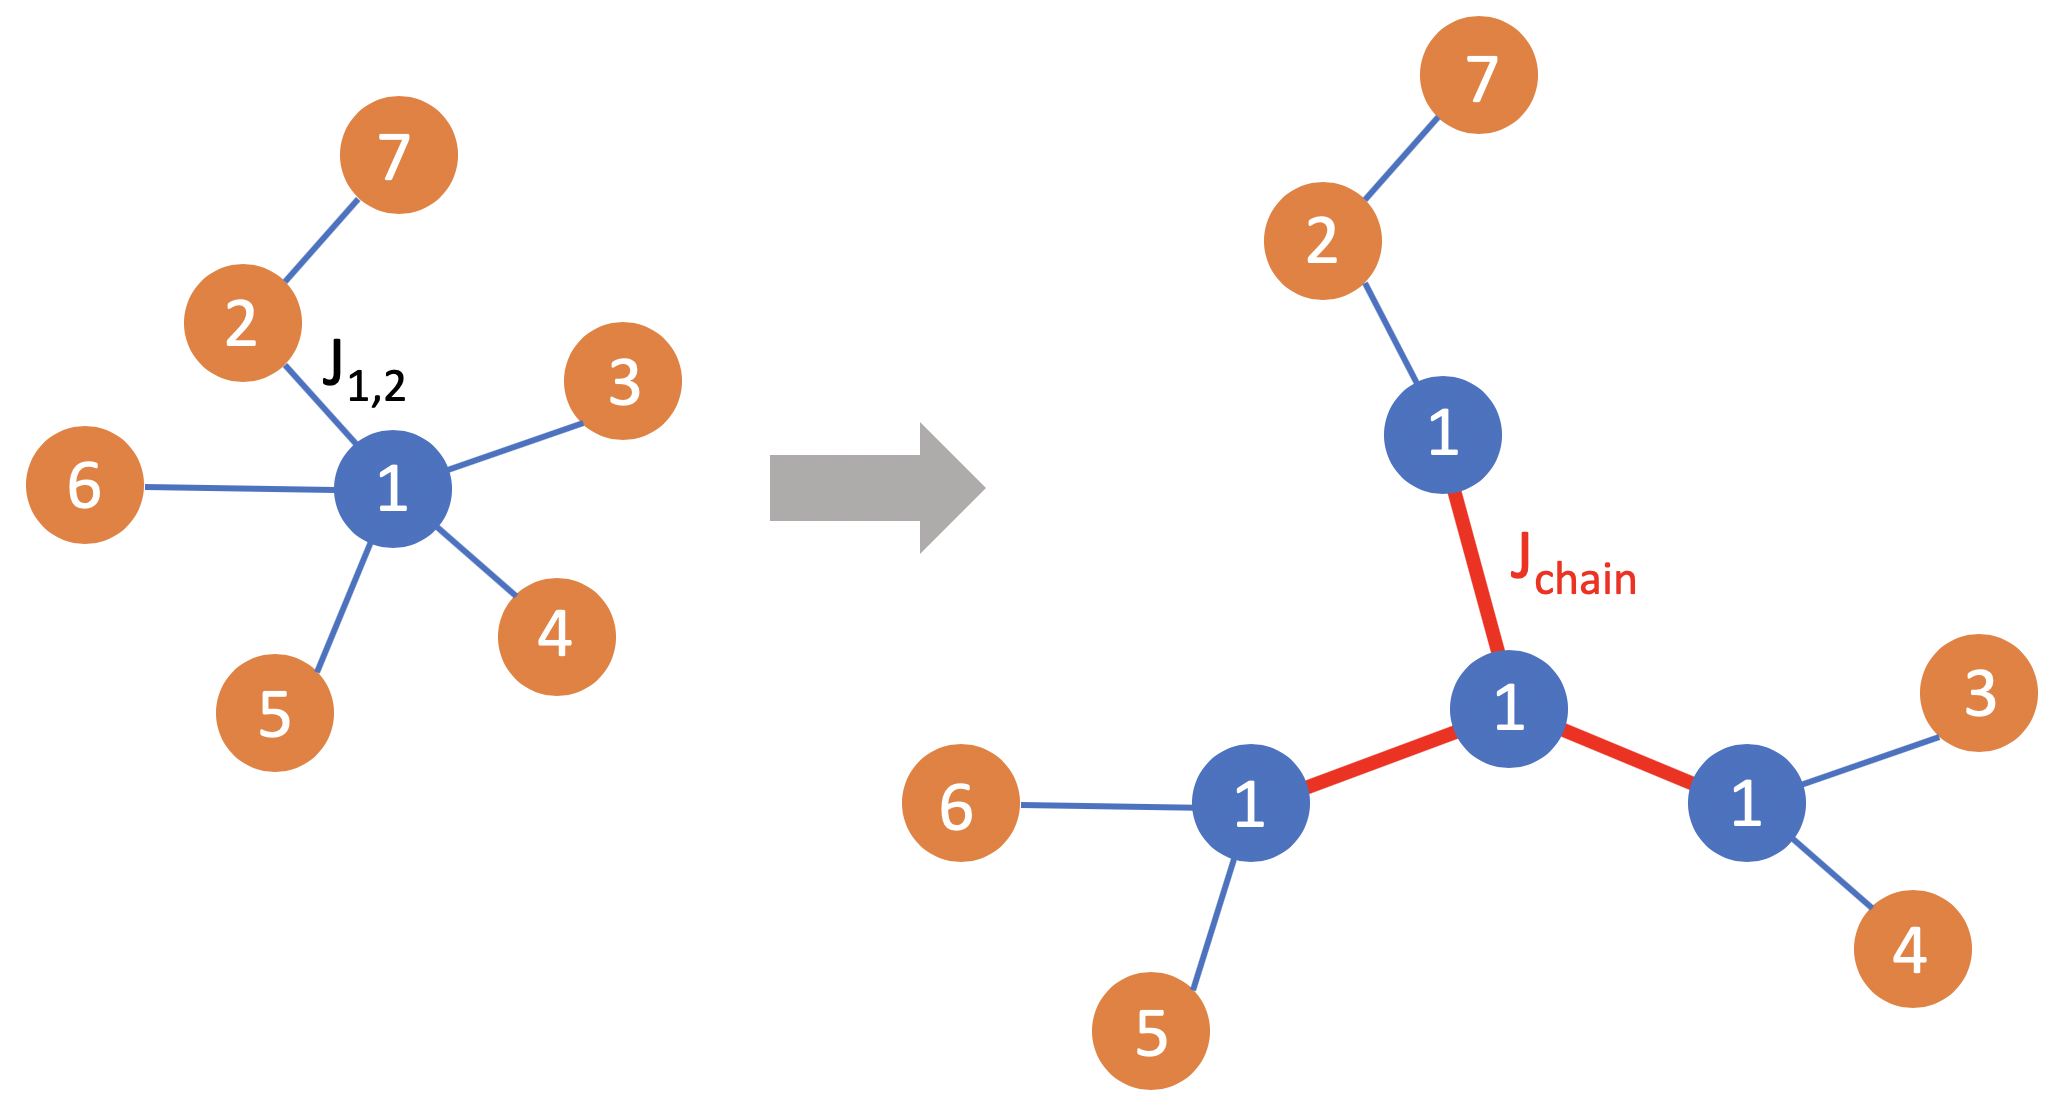

## IMPORTS and SETUP

In [1]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

__NOTE__: Please enter your S3 bucket and key below. 

In [3]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [4]:
# set D-Wave device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)


In [5]:
# investigate D-Wave device properties
device.properties.provider
device_name = device.name
qubit_count = device.properties.provider.qubitCount
number_couplers = len(device.properties.provider.couplers)
shots_range = device.properties.service.shotsRange
print('Running on {} with {} physical qubits, {} couplers and shots in the range {}.'.format(device_name,
                                                                                             qubit_count,
                                                                                             number_couplers,
                                                                                             shots_range))

Running on DW_2000Q_6 with 2048 physical qubits, 5974 couplers and shots in the range (1, 10000).


## EMBEDDING ON CHIMERA GRAPH: THE MINOR EMBEDDING PROBLEM 

Let us first have a closer look at the __minor embedding problem__. This part is __NP-hard__ in itself, so we typically have to resort to probabilistic heuristics to find an embedding. 
D-Wave's current hardware has 2048 qubits, consisting of $16 \times 16$ unit cells of $8$ qubits each.
The connectivity within such a unit cell of the Chimera graph is displayed below (with a figure taken from the D-Wave documentation [here](https://docs.dwavesys.com/docs/latest/c_gs_4.html)):  

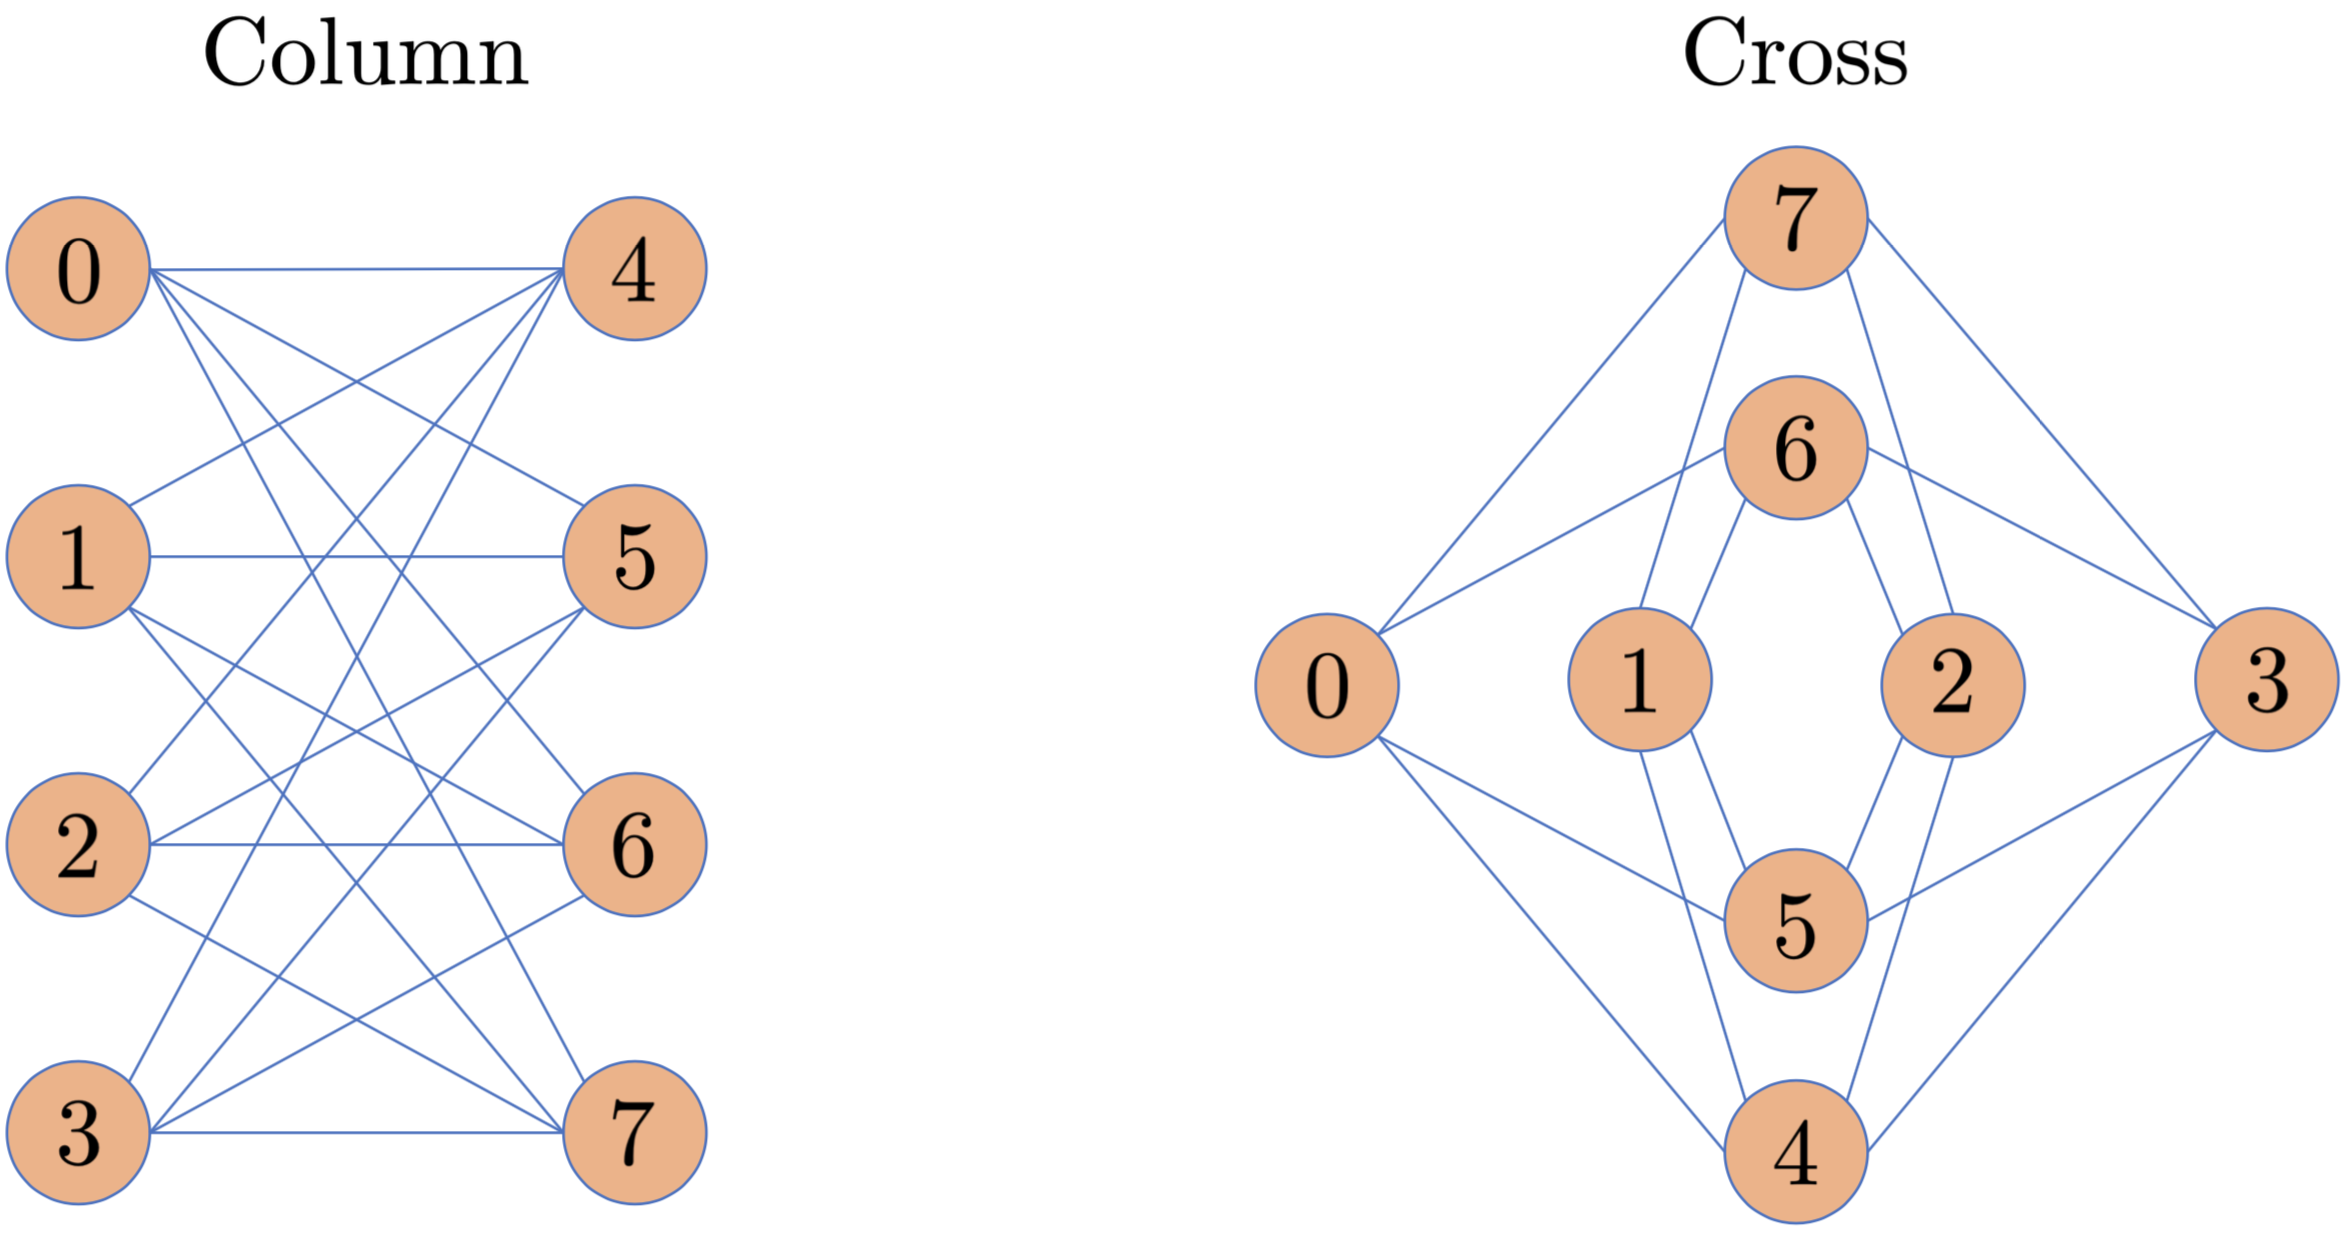

In [6]:
# print total number of qubits of current D-Wave chip
number_unit_cells = 16*16 # number of unit cells on 2D grid
qubits_cell = 8 # qubits per unit cell
number_qubits = number_unit_cells*qubits_cell
print('Current number of physical qubits on D-Wave chip:', number_qubits)

Current number of physical qubits on D-Wave chip: 2048


__Working graph__: As explained [here](https://docs.dwavesys.com/docs/latest/c_gs_4.html), in a D-Wave QPU, the set of qubits and couplers that are available for computation is known as the *working graph*. Because of production imperfections, the yield of a working graph is typically less than the total number of qubits and couplers that are fabricated and physically present in the QPU.

The Chimera graph is available as a ```networkx``` graph in the package ```dwave_networkx```. 
Using this package, we can visualize some small versions of the Chimera graph [2]. 

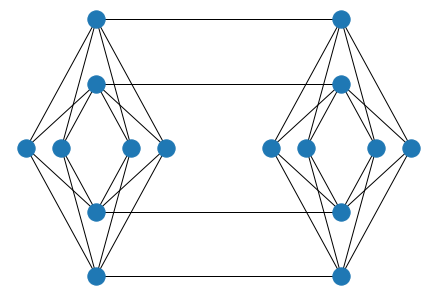

In [7]:
# show 1x2 Chimera graph
connectivity_structure = dnx.chimera_graph(1, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

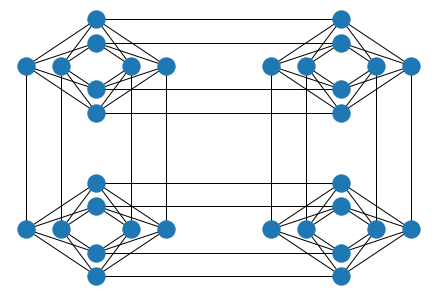

In [8]:
# show 2x2 Chimera graph
connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

As discussed above, sufficiently large, fully connected graphs $K_{n}$ do not fit onto the sparse Chimera graph. 
Let us consider a fully-connected graph with 9 vertices and try to find an embedding on a Chimera graph with $4\times8=32$ nodes. 

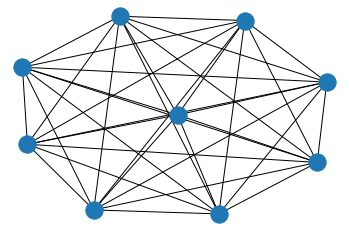

In [9]:
# get fully connected graph with 9 qubits
G = nx.complete_graph(9)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

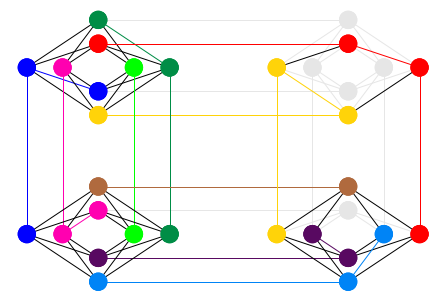

In [10]:
# find embedding on Chimera using minorminer
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

# plot this mebedding
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
plt.show()

Here, qubits that have the same colour correspond to one logical variable in the original problem defined by the $K_{9}$ graph. Qubits combined in such way form a chain. Even though our problem only has $9$ variables (nodes), we used a large portion of all 32 available physical qubits on the toy Chimera graph.

In [11]:
# print embedding
print(embedded_graph.items())

dict_items([(0, [16, 0, 6]), (1, [2, 18]), (2, [13, 5, 11, 27]), (3, [17, 21, 1]), (4, [15, 7, 8, 24]), (5, [31, 23, 26]), (6, [3, 19, 4]), (7, [28, 20]), (8, [30, 25, 22])])


In [12]:
# find the maximum chain length
max_chain_length = 0
for _, chain in embedded_graph.items():
    if len(chain) > max_chain_length:
        max_chain_length = len(chain)
print('Maximum chain length in embedded graph (overhead):', max_chain_length)

Maximum chain length in embedded graph (overhead): 4


The chain on the hardware is implemented by having very strong couplings between the elements in a chain (as indicated by the bold, red connections $J_{\mathrm{chain}}$ in the first figure), chosen as twice as strong as what the user can set. 
This enforces physical qubits to take on the same logical value. 
Still, long chains can break, leading to inconsistent results. 
In general, shorter chains (with smaller overhead) are preferable, so we do not waste physical qubits and we obtain more reliable results [2].

## SETTING UP AND SOLVING QUBO PROBLEMS 

In this section we show how to set up and solve QUBO (or Ising problems); we use several sampling strategies. 
For classical benchmarking we use ```SimulatedAnnealingSampler``` and ```ExactSolver``` that ship with D-Wave's ```dimod``` API. 
Finally, we show how to run the same problem on D-Wave's QPU using ```BraketDWaveSampler```. 
In general, any sampler accepts a binary quadratic model (BQM) as defined below as model input and returns variable assignments in its response. 

### PROBLEM SETUP

For concreteness we consider a graph-coloring problem on a simple, small graph with five vertices (labeled $0$ to $5$), six edges and maximum degree of three, as illustrated below. 
We seek a partition of all nodes into two subsets with maximum cut. 
Here, you score a point whenever an edge connects two nodes with different colors. 
This is the NP-hard [Maximum-Cut problem](https://en.wikipedia.org/wiki/Maximum_cut). 
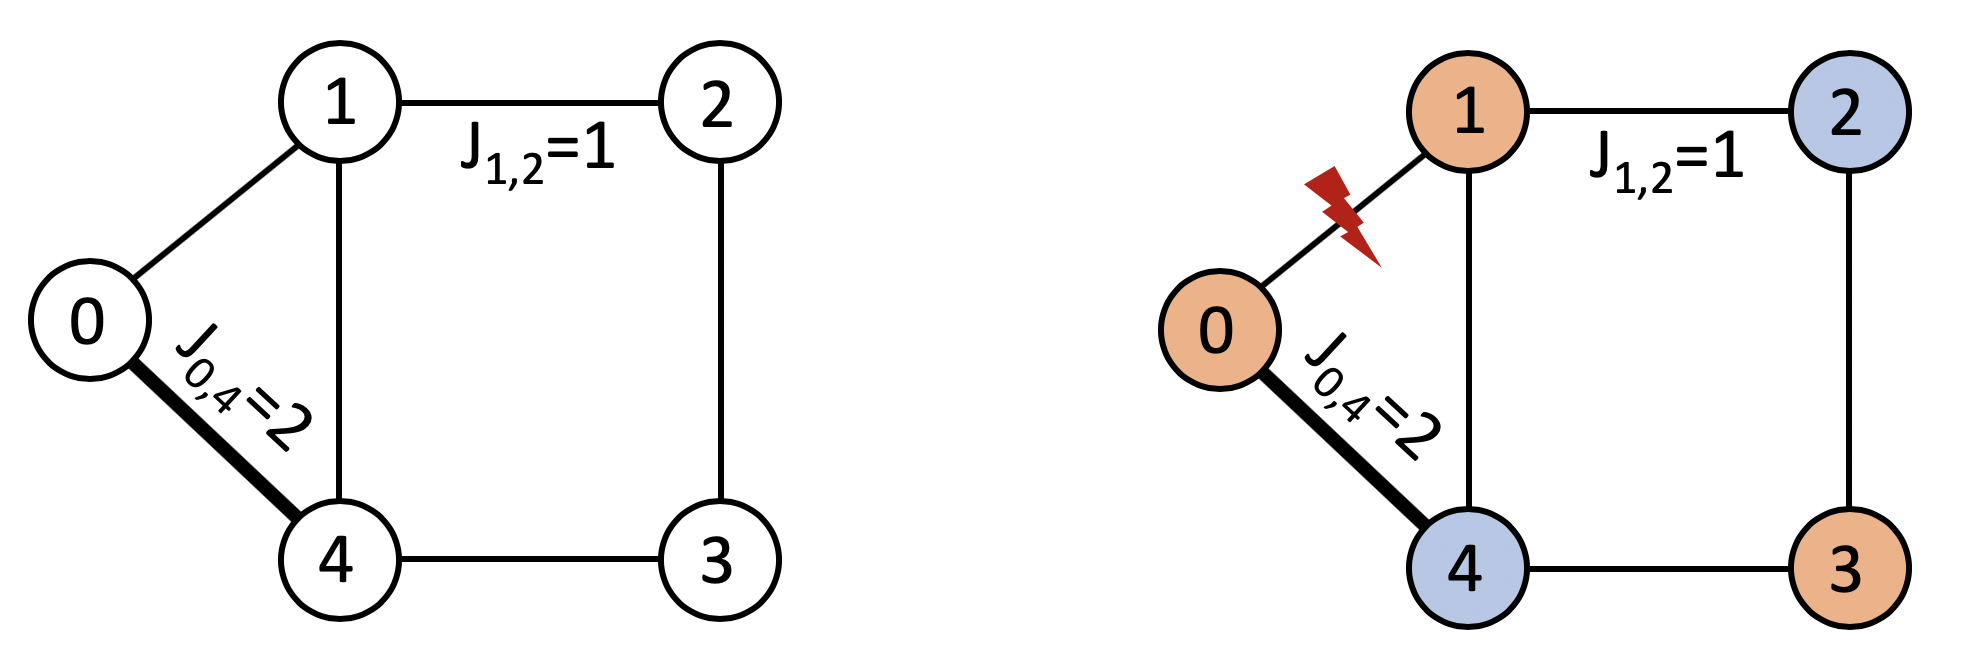

We set up the problem by defining (i) a constant offset term (which only affects the value of the energy but does not affect the variable configuration), and both (ii) linear and (iii) quadratic terms defined as dictionaries, as shown below. 

In [13]:
# define QUBO problem as BinaryQuadraticModel
quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
linear = {}
offset = 0.0

### CLASSICAL BENCHMARK: SIMULATED ANNEALING

First we run this problem using (classical) simulated annealing, as offered as part of D-Wave's ```dimod``` module; ```SimulatedAnnealingSampler``` is a [reference implementation](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampler_composites/samplers.html#module-dimod.reference.samplers.simulated_annealing) of a simulated annealing sampler, with ```neal.sampler.SimulatedAnnealingSampler``` being a more performant implementation of simulated annealing you may try to use for solving problems. 
We formulate this problem in Ising form with variables that take on the values $\pm 1$.

In [14]:
# set parameters
num_shots = 10
vartype = dimod.SPIN

# run classical simulated annealing
model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=num_shots)

# print results
print(response)

   0  1  2  3  4 energy num_oc.
0 +1 +1 -1 +1 -1   -5.0       1
1 +1 +1 -1 +1 -1   -5.0       1
2 -1 -1 +1 -1 +1   -5.0       1
3 +1 +1 -1 +1 -1   -5.0       1
4 +1 +1 -1 +1 -1   -5.0       1
5 -1 -1 +1 -1 +1   -5.0       1
6 -1 -1 +1 -1 +1   -5.0       1
7 -1 -1 +1 -1 +1   -5.0       1
8 -1 -1 +1 -1 +1   -5.0       1
9 +1 +1 -1 +1 -1   -5.0       1
['SPIN', 10 rows, 10 samples, 5 variables]


In the ```response``` object above we see that individual samples are listed as individual rows, with a lot of redundant information. 
We can access this information in more compact form using the ```aggregate()``` method as shown below and described [here](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/generated/dimod.SampleSet.aggregate.html). 

In [15]:
# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

   0  1  2  3  4 energy num_oc.
0 +1 +1 -1 +1 -1   -5.0       5
1 -1 -1 +1 -1 +1   -5.0       5
['SPIN', 2 rows, 10 samples, 5 variables]


We find two degenerate optimal solutions (shown above) with energy $-5.0$ that are connected by a so-called $\mathbb{Z}_{2}$ symmetry. 
In plain English, this simply means that the choice of coloring is arbitrary, since it does not make a difference if we color one set of nodes $\{0,1,3\}$ red and the remaining ones $\{2,4\}$ blue or the other way around. 
However, if we just add one linear term, this symmetry is broken and one unique solution is preferred as shown below. 

In [16]:
# modify QUBO: add linear term
linear_break = {0: +1.0}

# run classical simulated annealing
model = dimod.BinaryQuadraticModel(linear_break, quadratic, offset, vartype)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=num_shots)

# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

   0  1  2  3  4 energy num_oc.
0 -1 -1 +1 -1 +1   -6.0      10
['SPIN', 1 rows, 10 samples, 5 variables]


In [17]:
# we can determine the minimum
min_energy = min(response.data_vectors['energy'])
print('Minimal energy:', min_energy)

Minimal energy: -6.0


### CLASSICAL BENCHMARK: ```ExactSolver```

Alternatively, for this small introductory problem, we can use the ```ExactSolver```. 
The ```ExactSolver``` used here is a simple exact solver for testing and debugging code using your local CPU. 
Note that this solver becomes [slow](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampler_composites/samplers.html#samplers) for problems with $\sim18$ or more variables.
The ```ExactSolver``` simply reports all $2^{N}=32$ configurations with corresponding energies. 

In [18]:
# run exact solver
model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.ExactSolver()
response = sampler.sample(model)

# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

    0  1  2  3  4 energy num_oc.
8  -1 -1 +1 -1 +1   -5.0       1
29 +1 +1 -1 +1 -1   -5.0       1
4  -1 +1 -1 -1 +1   -3.0       1
9  +1 -1 +1 -1 +1   -3.0       1
11 -1 +1 +1 -1 +1   -3.0       1
14 +1 -1 +1 -1 -1   -3.0       1
17 +1 -1 +1 +1 -1   -3.0       1
27 -1 +1 -1 +1 +1   -3.0       1
28 -1 +1 -1 +1 -1   -3.0       1
30 +1 -1 -1 +1 -1   -3.0       1
2  +1 +1 -1 -1 -1   -1.0       1
7  -1 -1 -1 -1 +1   -1.0       1
13 +1 +1 +1 -1 -1   -1.0       1
18 +1 +1 +1 +1 -1   -1.0       1
23 -1 -1 +1 +1 +1   -1.0       1
24 -1 -1 -1 +1 +1   -1.0       1
1  +1 -1 -1 -1 -1    1.0       1
3  -1 +1 -1 -1 -1    1.0       1
6  +1 -1 -1 -1 +1    1.0       1
12 -1 +1 +1 -1 -1    1.0       1
19 -1 +1 +1 +1 -1    1.0       1
20 -1 +1 +1 +1 +1    1.0       1
22 +1 -1 +1 +1 +1    1.0       1
25 +1 -1 -1 +1 +1    1.0       1
5  +1 +1 -1 -1 +1    3.0       1
10 +1 +1 +1 -1 +1    3.0       1
15 -1 -1 +1 -1 -1    3.0       1
16 -1 -1 +1 +1 -1    3.0       1
26 +1 +1 -1 +1 +1    3.0       1
31 -1 -1 -

### QUANTUM ANNEALING ON D-WAVE

Finally, we show how to run the same problem on D-Wave's QPU using ```BraketDWaveSampler```. Before doing so, let us discuss some features in some more detail:  
* __Number of samples__: With the parameter ```num_reads``` we set the number of samples we would like to obtain. Given the probabilistic nature of quantum annealing, the annealer will not find the optimal solution in every single run, but for the simple problem considered here the vast majority of runs should find one of the two optimal bitstrings. 
* __Storage of results__: When defining the ```BraketDWaveSampler``` object, we also pass the ```s3_folder``` (defined above) as parameter; all results will be reliably stored in this S3 location. 
* __Physical vs. logical variables__: If samples agree on the logical encoding level, but are different on the physical level (because chains may break, as discussed above), then (for full transparency) D-Wave reports these as separate rows. If this information is somewhat redundant for you, you may simplify the output by calling the ```aggregate()``` method, as shown below. 
* __Embedding__: D-Wave's ```EmbeddingComposite()``` implements the minor-mapping strategy, by mapping the problem graph to D-Wave system’s numerically indexed qubits. Note that a new minor- embedding is calculated each time one of its sampling methods is called. If you want to provide your own embedding, you can do so by using ```FixedEmbeddingComposite``` instead. More details on composites can be found [here](https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/composites.html). 

In [19]:
# set parameters
num_reads = 1000
vartype = dimod.SPIN

# define BQM
bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

# run BQM: solve with D-Wave device
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
sampleset = sampler.sample(bqm, num_reads=num_reads)

# print solution
print(sampleset)

   0  1  2  3  4 energy num_oc. chain_.
0 +1 +1 -1 +1 -1   -5.0     248     0.0
1 -1 -1 +1 -1 +1   -5.0     178     0.0
2 -1 +1 -1 +1 +1   -3.0      81     0.2
3 +1 -1 +1 -1 +1   -3.0     490     0.2
4 +1 -1 +1 +1 -1   -3.0       1     0.0
5 +1 -1 +1 -1 -1   -3.0       2     0.0
['SPIN', 6 rows, 1000 samples, 5 variables]


In your output you may see identical logical results listed as separate rows in the sample set results object. 
See for example the first and third line in the screen shot below. 
This is because these results are different on the physical level of variables, as evident from the last column ```chain_.``` giving different chain breaking results and therefore indicating different configurations on the physical level. 
If you are not interested about this extra information, and are only concerned about the logical level, we can just call ```aggregate()``` and simplify the output as shown below. 
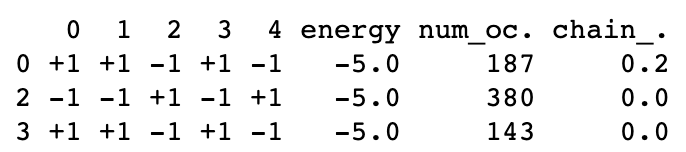

In [20]:
# set parameters
num_reads = 1000

# define BQM
bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

# run BQM: solve with D-Wave device
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
sampleset = sampler.sample(bqm, num_reads=num_reads)

# aggregate solution: 
sampleset = sampleset.aggregate()

# print solution
print(sampleset)

   0  1  2  3  4 energy num_oc. chain_.
0 +1 +1 -1 +1 -1   -5.0     669     0.0
1 -1 -1 +1 -1 +1   -5.0     136     0.0
2 +1 -1 +1 -1 +1   -3.0     194     0.2
3 -1 +1 -1 +1 +1   -3.0       1     0.0
['SPIN', 4 rows, 1000 samples, 5 variables]


In [21]:
# print s3 folder where results are stored
print('Results are stored here:', s3_folder)

Results are stored here: ('amazon-braket-512393695560', 'simulation-output')


## EXPERIMENTS WITH ANNEALING PARAMETERS

In this section we dive a little bit deeper into the sampling process as performed on D-Wave's QPU. 
To this end we analyze a breakdown of the QPU access time as a function of the QUBO problem size and parameters we can set as parameters. 
As shown below we can access several timing-related fields available in D-Wave’s Ocean SDK, using the ```info``` field in the dimod sample set class. Compare information available [here](https://docs.dwavesys.com/docs/latest/c_timing_5.html#qpu-timing-information-from-ocean-software). 

In [22]:
# print timing info for previous D-Wave job shown above
sampleset.info['additionalMetadata']['dwaveMetadata']['timing']

{'qpuSamplingTime': 238940,
 'qpuAnnealTimePerSample': 20,
 'qpuAccessTime': 249621,
 'qpuAccessOverheadTime': 3063,
 'qpuReadoutTimePerSample': 198,
 'qpuProgrammingTime': 10681,
 'qpuDelayTimePerSample': 21,
 'postProcessingOverheadTime': 743,
 'totalPostProcessingTime': 743,
 'totalRealTime': 249621,
 'runTimeChip': 238940,
 'annealTimePerRun': 20,
 'readoutTimePerRun': 198}

In our experimental runs below, we will focus on the total QPU access time ```QpuAccessTime``` which can be broken up into two contributions: 
(1) a one-time initialization step to program the QPU (given by ```QpuProgrammingTime```), and 
(2) the total sampling time ```QpuSamplingTime``` that is made of repeated sampling runs involving per-sample timescales such as ```QpuAnnealTimePerSample``` and ```QpuReadoutTimePerSample```.
For more details, we refer to [this page](https://docs.dwavesys.com/docs/latest/c_timing_2.html#breakdown-of-qpu-access-time) in the Ocean documentation.  

We will analyze how these timescales depend on the number of logical variables for a canonical NP-hard QUBO problem, namely a specific graph partitioning problem as described in great detail [here](https://github.com/dwave-examples/graph-partitioning).
In short, here the goal is to partition all nodes into two subsets of equal size while minimizing the number of cut edges between these two subsets. 
In other words, we need to color the graph such that we have the same number of blue and red nodes with the number of edges connecting blue and red nodes being as small as possible. 

### EXPERIMENTS WITH ANNEALING PARAMETERS: HELPER FUNCTIONS

Let us first set up some helper functions we will use below. 
The function ```get_graph``` plots a given graph using the ```networkx``` library. 
The function ```get_model``` generates the QUBO $Q$-matrix for graph partitioning problem based on a random graph with a given number of nodes and edge probability. 
The function ```run_qubo``` runs the QUBO problem for given graph $G$, associated Qubo-Matrix $Q$ and number of shots, outputting several timescales discussed above. 

In [23]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot given graph with fixed positioning
    """
    
    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=400)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [24]:
def get_model(nodes, prob=0.2, gamma=80):
    """
    function to generate Q matrix for graph partitioning problem 
    """
    
    # ------- Set up our graph -------
    vertices = nodes
    G = nx.gnp_random_graph(vertices, prob)

    print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
                                                                               len(G.edges), 
                                                                               len(G.nodes) * (len(G.nodes)-1) / 2))

    # ------- Plot our graph -------
    pos = nx.spring_layout(G)
    # plot graph with labels
    get_graph(G, pos)

    # ------- Set up our QUBO dictionary -------

    # Initialize our Q matrix
    Q = defaultdict(int)

    # Fill in Q matrix
    for u, v in G.edges:
        Q[(u,u)] += 1
        Q[(v,v)] += 1
        Q[(u,v)] += -2

    for i in G.nodes:
        Q[(i,i)] += gamma*(1-len(G.nodes))

    for i, j in combinations(G.nodes, 2):
        Q[(i,j)] += 2*gamma
    
    return G, Q

In [25]:
def run_qubo(G, Q, gamma=80, num_reads=1000, annealing_time=20):
    """
    run QUBO problem for given graph G, Qubo-Matrix Q and number of shots
    """
    # ------- Run our QUBO on the QPU -------

    # Set chain strength
    nodes = len(G.nodes)
    chain_strength = gamma*nodes

    # Run QUBO on Braket and keep track of runtime
    start = time.time()
    response = sampler.sample_qubo(Q, chain_strength=chain_strength, 
                                   num_reads=num_reads,
                                   annealing_time=annealing_time)
    end = time.time()
    
    # print and store runtime (wallclock time)
    runtime = end - start
    print('Runtime is {} for {} nodes.'.format(runtime, nodes))
    
    # D-Wave timescales
    QpuSamplingTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuSamplingTime']
    QpuAccessTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']
    QpuProgrammingTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuProgrammingTime']
    QpuAnnealTimePerSample = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAnnealTimePerSample']
    # TotalRealTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['totalRealTime']
    # RunTimeChip = response.info['additionalMetadata']['dwaveMetadata']['timing']['runTimeChip']
    print('QpuProgrammingTime is {} for {} nodes.'.format(QpuProgrammingTime, nodes))
    print('QpuSamplingTime is {} for {} nodes.'.format(QpuSamplingTime, nodes))
    print('QpuAccessTime is {} for {} nodes.'.format(QpuAccessTime, nodes))
    print('QpuAnnealTimePerSample is {} for {} nodes.'.format(QpuAnnealTimePerSample, nodes))
    
    # See if the best solution found is feasible, and if so print the number of cut edges.
    sample = response.record.sample[0]

    # Postprocessing: analyze result
    # In the case when n is odd, the set may have one more or one fewer nodes
    if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
        num_cut_edges = 0
        for u, v in G.edges:
            num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
        print("Valid partition found with", num_cut_edges, "cut edges.")
    else:
        print("Invalid partition.")
    
    # plot result
    colors = sample
    colorlist = ['#377eb8','#e41a1c']
    nx.draw_networkx(graph, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    plt.axis('off');
    plt.show();
    
    # results as dic
    results = {'runtime': runtime, 
               'QpuSamplingTime': QpuSamplingTime,
               'QpuAccessTime': QpuAccessTime, 
               'QpuProgrammingTime': QpuProgrammingTime,
               'QpuAnnealTimePerSample': QpuAnnealTimePerSample
              }
    
    return results

### EXPERIMENTS WITH ANNEALING PARAMETERS: EXPERIMENTAL RUNS

Graph on 10 nodes created with 7 out of 45.0 possible edges.


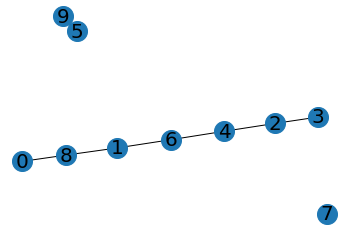

Runtime is 7.077903747558594 for 10 nodes.
QpuProgrammingTime is 10746 for 10 nodes.
QpuSamplingTime is 2289 for 10 nodes.
QpuAccessTime is 13035 for 10 nodes.
QpuAnnealTimePerSample is 10 for 10 nodes.
Valid partition found with 2 cut edges.


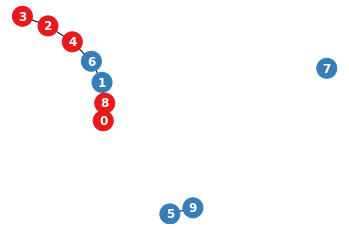

Graph on 20 nodes created with 39 out of 190.0 possible edges.


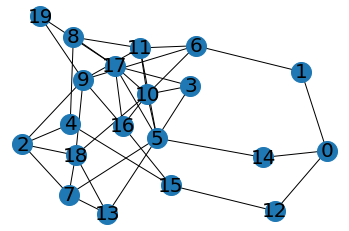

Runtime is 8.452486038208008 for 20 nodes.
QpuProgrammingTime is 10847 for 20 nodes.
QpuSamplingTime is 2289 for 20 nodes.
QpuAccessTime is 13137 for 20 nodes.
QpuAnnealTimePerSample is 10 for 20 nodes.
Valid partition found with 20 cut edges.


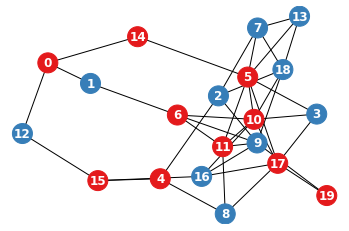

Graph on 30 nodes created with 89 out of 435.0 possible edges.


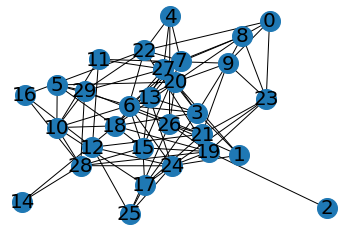

Runtime is 8.128462076187134 for 30 nodes.
QpuProgrammingTime is 10934 for 30 nodes.
QpuSamplingTime is 2289 for 30 nodes.
QpuAccessTime is 13223 for 30 nodes.
QpuAnnealTimePerSample is 10 for 30 nodes.
Valid partition found with 44 cut edges.


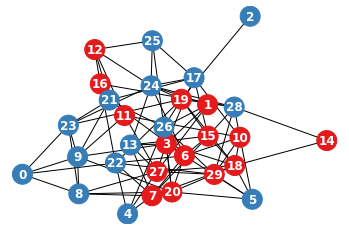

Graph on 40 nodes created with 148 out of 780.0 possible edges.


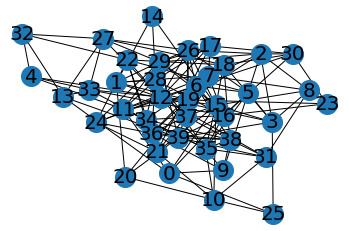

Runtime is 18.380165338516235 for 40 nodes.
QpuProgrammingTime is 10907 for 40 nodes.
QpuSamplingTime is 2289 for 40 nodes.
QpuAccessTime is 13196 for 40 nodes.
QpuAnnealTimePerSample is 10 for 40 nodes.
Invalid partition.


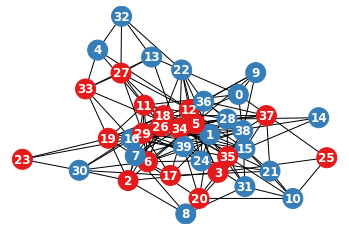

Graph on 50 nodes created with 258 out of 1225.0 possible edges.


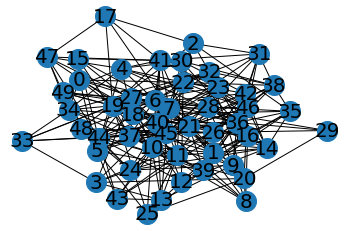

Runtime is 17.621442079544067 for 50 nodes.
QpuProgrammingTime is 10950 for 50 nodes.
QpuSamplingTime is 2289 for 50 nodes.
QpuAccessTime is 13240 for 50 nodes.
QpuAnnealTimePerSample is 10 for 50 nodes.
Invalid partition.


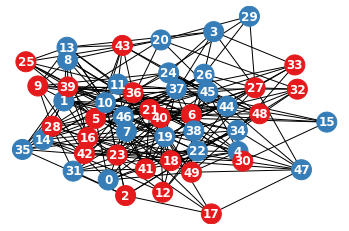

Graph on 60 nodes created with 319 out of 1770.0 possible edges.


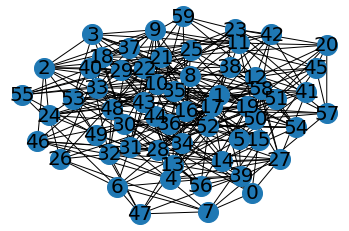

Runtime is 24.439469814300537 for 60 nodes.
QpuProgrammingTime is 11011 for 60 nodes.
QpuSamplingTime is 2289 for 60 nodes.
QpuAccessTime is 13300 for 60 nodes.
QpuAnnealTimePerSample is 10 for 60 nodes.
Invalid partition.


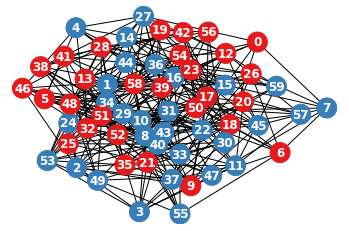

In [26]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 10 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes = [] # stores individual runtimes
QpuSamplingTimes = [] 
QpuAccessTimes = [] 
QpuProgrammingTimes = [] 
QpuAnnealTimePerSamples = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes.append(runtime)
    QpuSamplingTimes.append(QpuSamplingTime)
    QpuAccessTimes.append(QpuAccessTime)
    QpuProgrammingTimes.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples.append(QpuAnnealTimePerSample)

We run a second set of experimetns for the same parameters in order to verify the trends we observe. 

Graph on 10 nodes created with 12 out of 45.0 possible edges.


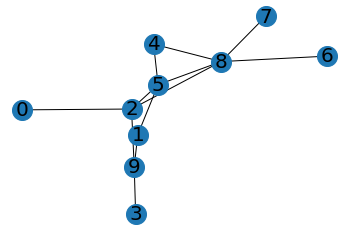

Runtime is 7.7406089305877686 for 10 nodes.
QpuProgrammingTime is 10772 for 10 nodes.
QpuSamplingTime is 2289 for 10 nodes.
QpuAccessTime is 13062 for 10 nodes.
QpuAnnealTimePerSample is 10 for 10 nodes.
Valid partition found with 6 cut edges.


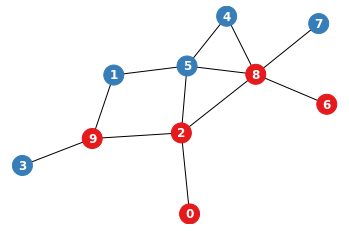

Graph on 20 nodes created with 40 out of 190.0 possible edges.


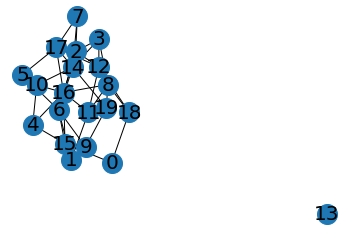

Runtime is 6.635346174240112 for 20 nodes.
QpuProgrammingTime is 10819 for 20 nodes.
QpuSamplingTime is 2289 for 20 nodes.
QpuAccessTime is 13108 for 20 nodes.
QpuAnnealTimePerSample is 10 for 20 nodes.
Valid partition found with 22 cut edges.


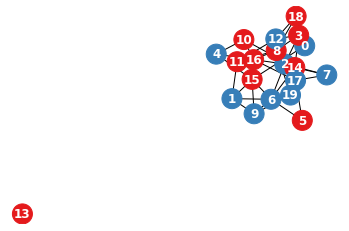

Graph on 30 nodes created with 97 out of 435.0 possible edges.


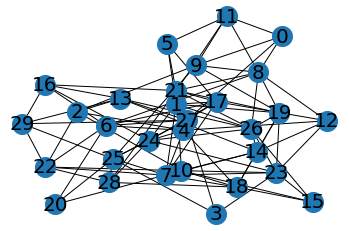

Runtime is 9.409617185592651 for 30 nodes.
QpuProgrammingTime is 10933 for 30 nodes.
QpuSamplingTime is 2289 for 30 nodes.
QpuAccessTime is 13222 for 30 nodes.
QpuAnnealTimePerSample is 10 for 30 nodes.
Valid partition found with 49 cut edges.


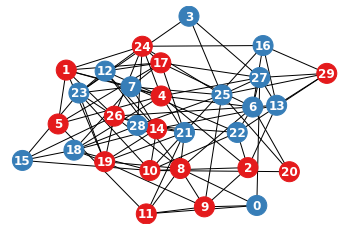

Graph on 40 nodes created with 156 out of 780.0 possible edges.


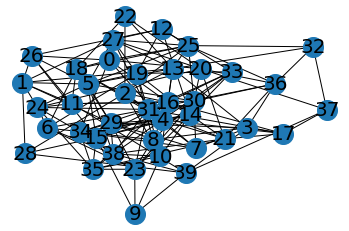

Runtime is 20.978790283203125 for 40 nodes.
QpuProgrammingTime is 10924 for 40 nodes.
QpuSamplingTime is 2289 for 40 nodes.
QpuAccessTime is 13214 for 40 nodes.
QpuAnnealTimePerSample is 10 for 40 nodes.
Invalid partition.


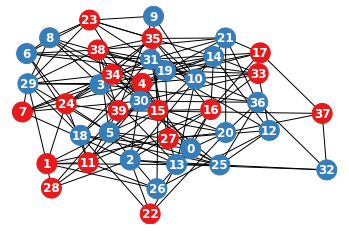

Graph on 50 nodes created with 226 out of 1225.0 possible edges.


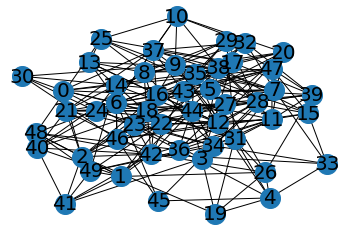

Runtime is 18.41852903366089 for 50 nodes.
QpuProgrammingTime is 10973 for 50 nodes.
QpuSamplingTime is 2289 for 50 nodes.
QpuAccessTime is 13262 for 50 nodes.
QpuAnnealTimePerSample is 10 for 50 nodes.
Valid partition found with 112 cut edges.


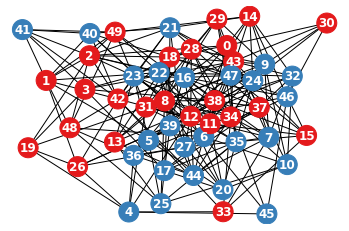

Graph on 60 nodes created with 360 out of 1770.0 possible edges.


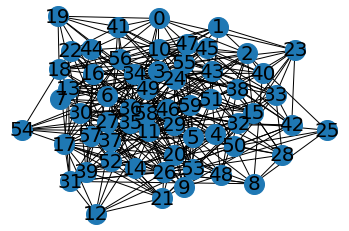

Runtime is 16.59036111831665 for 60 nodes.
QpuProgrammingTime is 11002 for 60 nodes.
QpuSamplingTime is 2289 for 60 nodes.
QpuAccessTime is 13291 for 60 nodes.
QpuAnnealTimePerSample is 10 for 60 nodes.
Valid partition found with 199 cut edges.


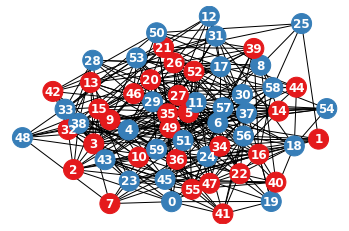

In [27]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 10 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes2 = [] # stores individual runtimes
QpuSamplingTimes2 = [] 
QpuAccessTimes2 = [] 
QpuProgrammingTimes2 = [] 
QpuAnnealTimePerSamples2 = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes2.append(runtime)
    QpuSamplingTimes2.append(QpuSamplingTime)
    QpuAccessTimes2.append(QpuAccessTime)
    QpuProgrammingTimes2.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples2.append(QpuAnnealTimePerSample)

### EXPERIMENTS WITH ANNEALING PARAMETERS: VISUALIZATION

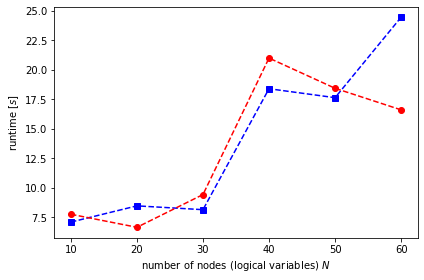

In [28]:
# plot wallclock results
plt.plot(nodes, runtimes, 'b--s')
plt.plot(nodes, runtimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('runtime $[s]$')
plt.tight_layout();
plt.savefig('dwave_wallclock_partitioning_shots_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

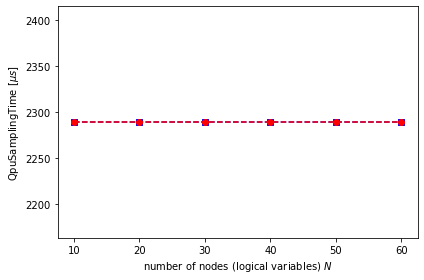

In [29]:
# plot QpuSamplingTimes results
plt.plot(nodes, QpuSamplingTimes, 'b--s')
plt.plot(nodes, QpuSamplingTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuSamplingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuSamplingTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

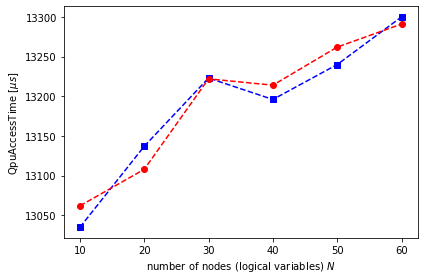

In [30]:
# plot QpuAccessTimes results
plt.plot(nodes, QpuAccessTimes, 'b--s')
plt.plot(nodes, QpuAccessTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAccessTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAccessTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

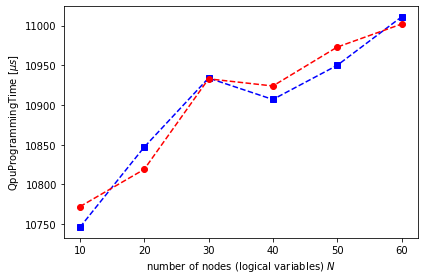

In [31]:
# plot QpuProgrammingTimes results
plt.plot(nodes, QpuProgrammingTimes, 'b--s')
plt.plot(nodes, QpuProgrammingTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuProgrammingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuProgrammingTime_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

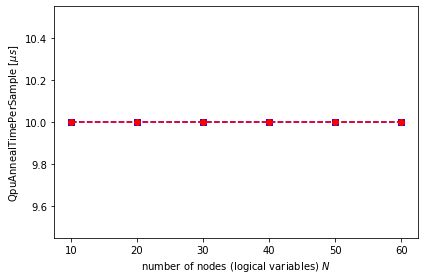

In [32]:
# plot QpuAnnealTimePerSamples results
plt.plot(nodes, QpuAnnealTimePerSamples, 'b--s')
plt.plot(nodes, QpuAnnealTimePerSamples2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAnnealTimePerSample $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAnnealTimePerSample_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

We can make the following observations: 
The wallclock time we experience as a user tends to increase with the number of variables, potentially showing spikes that can come from somewhat random queuing times. 
All other timescales we report are independent of queuing. 
The total QPU access time increases with the number of variables, following the trend given by the QPU programming time, while the QPU sampling time is a flat contribution to the QPU access time. 
The QPU anneal time per sample is constant, taking on the value we have set with the ```annealing_time``` parameter.
To investigate the dependence of all timescales on this parameter, let us run another set of experiments with a different value for this parameter. 

Graph on 10 nodes created with 7 out of 45.0 possible edges.


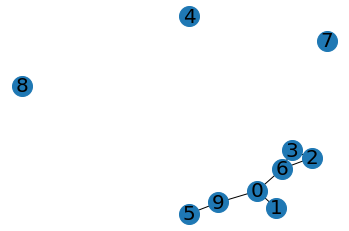

Runtime is 7.117043972015381 for 10 nodes.
QpuProgrammingTime is 10770 for 10 nodes.
QpuSamplingTime is 3189 for 10 nodes.
QpuAccessTime is 13959 for 10 nodes.
QpuAnnealTimePerSample is 100 for 10 nodes.
Valid partition found with 2 cut edges.


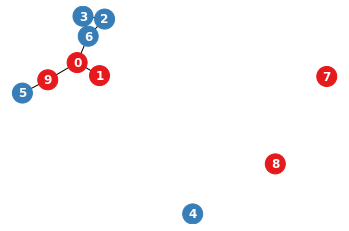

Graph on 20 nodes created with 40 out of 190.0 possible edges.


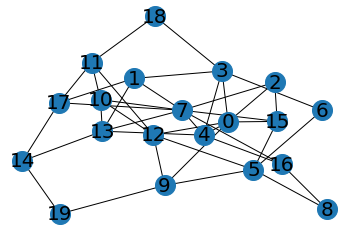

Runtime is 7.404282808303833 for 20 nodes.
QpuProgrammingTime is 10891 for 20 nodes.
QpuSamplingTime is 3189 for 20 nodes.
QpuAccessTime is 14080 for 20 nodes.
QpuAnnealTimePerSample is 100 for 20 nodes.
Valid partition found with 25 cut edges.


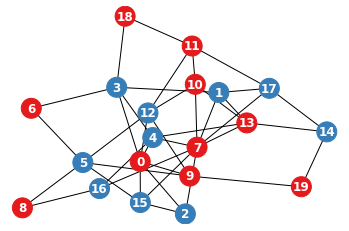

Graph on 30 nodes created with 98 out of 435.0 possible edges.


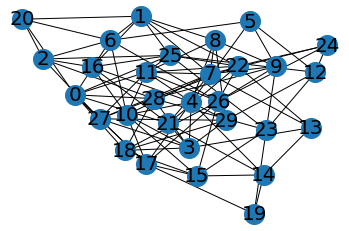

Runtime is 13.139211893081665 for 30 nodes.
QpuProgrammingTime is 10949 for 30 nodes.
QpuSamplingTime is 3189 for 30 nodes.
QpuAccessTime is 14138 for 30 nodes.
QpuAnnealTimePerSample is 100 for 30 nodes.
Valid partition found with 48 cut edges.


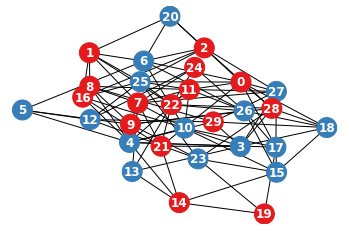

Graph on 40 nodes created with 176 out of 780.0 possible edges.


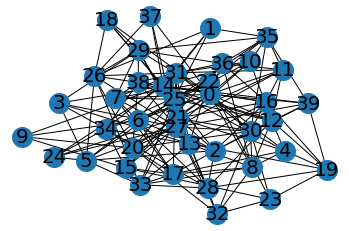

Runtime is 21.78826379776001 for 40 nodes.
QpuProgrammingTime is 10963 for 40 nodes.
QpuSamplingTime is 3189 for 40 nodes.
QpuAccessTime is 14152 for 40 nodes.
QpuAnnealTimePerSample is 100 for 40 nodes.
Valid partition found with 93 cut edges.


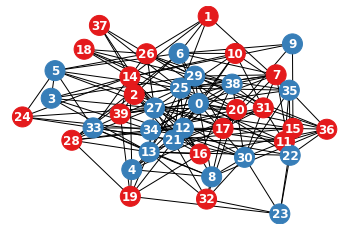

Graph on 50 nodes created with 247 out of 1225.0 possible edges.


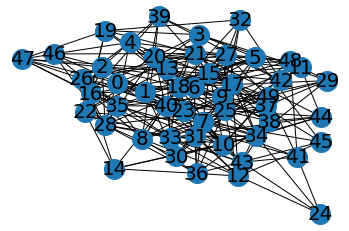

Runtime is 22.86950707435608 for 50 nodes.
QpuProgrammingTime is 10959 for 50 nodes.
QpuSamplingTime is 3189 for 50 nodes.
QpuAccessTime is 14149 for 50 nodes.
QpuAnnealTimePerSample is 100 for 50 nodes.
Invalid partition.


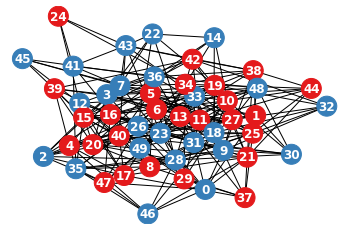

Graph on 60 nodes created with 365 out of 1770.0 possible edges.


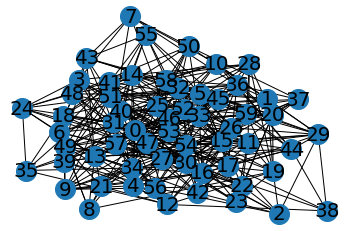

Runtime is 13.484812021255493 for 60 nodes.
QpuProgrammingTime is 11028 for 60 nodes.
QpuSamplingTime is 3189 for 60 nodes.
QpuAccessTime is 14217 for 60 nodes.
QpuAnnealTimePerSample is 100 for 60 nodes.
Invalid partition.


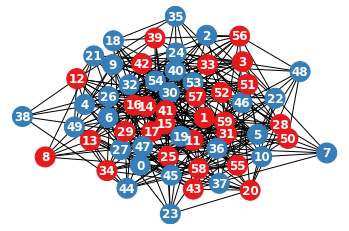

In [34]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 100 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes3 = [] # stores individual runtimes
QpuSamplingTimes3 = [] 
QpuAccessTimes3 = [] 
QpuProgrammingTimes3 = [] 
QpuAnnealTimePerSamples3 = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes3.append(runtime)
    QpuSamplingTimes3.append(QpuSamplingTime)
    QpuAccessTimes3.append(QpuAccessTime)
    QpuProgrammingTimes3.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples3.append(QpuAnnealTimePerSample)

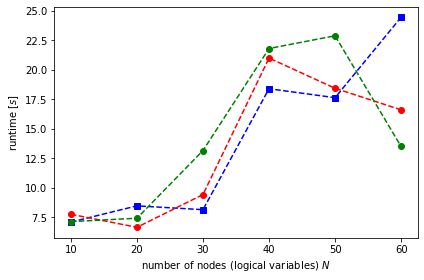

In [35]:
# plot runtime results
plt.plot(nodes, runtimes, 'b--s')
plt.plot(nodes, runtimes2, 'r--o')
plt.plot(nodes, runtimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('runtime $[s]$')
plt.tight_layout();
plt.savefig('dwave_wallclock_partitioning_shots_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

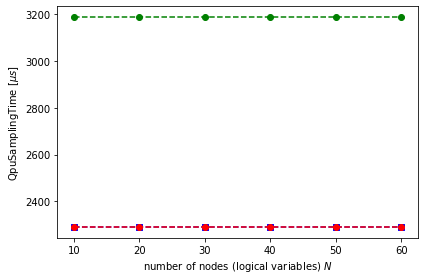

In [36]:
# plot runtime results
plt.plot(nodes, QpuSamplingTimes, 'b--s')
plt.plot(nodes, QpuSamplingTimes2, 'r--o')
plt.plot(nodes, QpuSamplingTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuSamplingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuSamplingTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

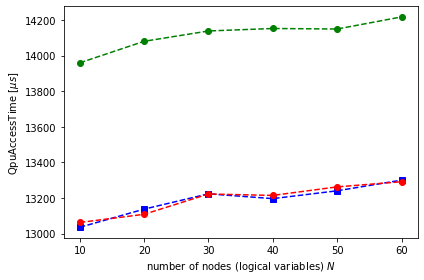

In [37]:
# plot runtime results
plt.plot(nodes, QpuAccessTimes, 'b--s')
plt.plot(nodes, QpuAccessTimes2, 'r--o')
plt.plot(nodes, QpuAccessTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAccessTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAccessTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

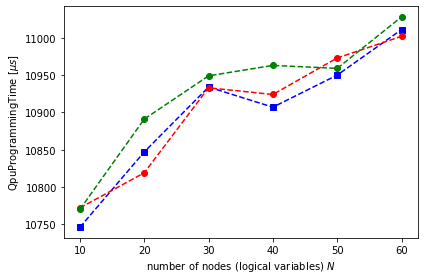

In [38]:
# plot runtime results
plt.plot(nodes, QpuProgrammingTimes, 'b--s')
plt.plot(nodes, QpuProgrammingTimes2, 'r--o')
plt.plot(nodes, QpuProgrammingTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuProgrammingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuProgrammingTime_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

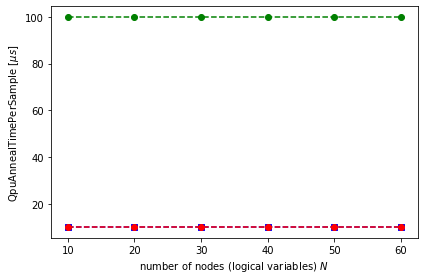

In [39]:
# plot runtime results
plt.plot(nodes, QpuAnnealTimePerSamples, 'b--s')
plt.plot(nodes, QpuAnnealTimePerSamples2, 'r--o')
plt.plot(nodes, QpuAnnealTimePerSamples3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAnnealTimePerSample $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAnnealTimePerSample_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

As expected, by increasing the ```annealing_time``` (per sample) we have increased the total QPU sampling times, thereby increasing the total QPU access time, while the QPU programming time has been left unaffected by this change. 

---
## REFERENCES

[1] F. Glover, G. Kochenberger, and Y. Du, *A Tutorial on Formulating and Using QUBO Models*, available online [here](http://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf). 

[2] P. Wittek, *Quantum Machine Learning*, [EdX online course](https://www.edx.org/course/quantum-machine-learning). 

In [40]:
# check the Braket SDK version
!pip show amazon-braket-sdk | grep Version

Version: 0.5.0
